In [9]:
%load_ext autoreload
%autoreload 2

from collections import OrderedDict
import cv2
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.direct_pose_and_param_estimation.dataset_mapper import XenRCNNMapper
import scene_generation.inverse_graphics.direct_pose_and_param_estimation.roi_heads as roi_heads
import scene_generation.inverse_graphics.direct_pose_and_param_estimation.meta_arch as meta_arch

np.set_printoptions(precision=2)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"

%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from scene_generation.inverse_graphics.synthetic_scene_database_loader import load_xencoco_json

DatasetCatalog.clear()
def load_dataset(d):
    return load_xencoco_json(
        os.path.join(DATA_ROOT, "%s.json" % (d)),
        data_root=DATA_ROOT,
        dataset_name="synthetic_%s" % d)
def load_real_dataset():
    return detectron2.data.datasets.load_coco_json(
        "/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json",
        image_root="/home/gizatt/data/coco/cardboard_boxes_in_wild/images",
        dataset_name="prime_boxes_real", extra_annotation_keys=None)
for d in ["train", "test"]:
    DatasetCatalog.register("synthetic_" + d, lambda d=d: load_dataset(d))
DatasetCatalog.register("prime_boxes_real", load_real_dataset)
synthetic_train_metadata = MetadataCatalog.get("synthetic_train")
real_prime_boxes_metadata = MetadataCatalog.get("prime_boxes_real")
real_prime_boxes_metadata.set(json_file="/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json")
print("Metadata train: ", synthetic_train_metadata)
print("Metadata real: ", real_prime_boxes_metadata)
DatasetCatalog.register("synthetic_5_types", lambda: load_dataset("scene_groups_5_types"))

Metadata train:  Metadata(name='synthetic_train')
Metadata real:  Metadata(json_file='/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json', name='prime_boxes_real')


In [11]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(DETECTRON_ROOT, "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.INPUT.MIN_SIZE_TRAIN = (480)
cfg.INPUT.MIN_SIZE_TEST = (480)
cfg.INPUT.DEPTH_FORMAT = 'L'
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.DATASETS.TRAIN = ("synthetic_train",)
cfg.DATASETS.TEST = ("synthetic_5_types",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNNWithDepthAndCalibration"
cfg.MODEL.DEPTH_PIXEL_MEAN = 1. # Totally made up
cfg.MODEL.DEPTH_PIXEL_STD = 1.
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (prime box)
cfg.MODEL.ROI_HEADS.NAME = "XenRCNNROIHeads"

cfg.MODEL.ROI_HEADS.SHAPE_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_HEADS.POSE_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_HEADS.SHAPE_LOSS_NORM = 'l1'
cfg.MODEL.ROI_HEADS.POSE_LOSS_NORM = 'l1'

cfg.MODEL.MASK_ON = True
cfg.MODEL.SHAPE_ON = True
cfg.MODEL.POSE_ON = True
cfg.MODEL.POSE_6DOF_ROT_ON = False # False -> Predict RPY as in 3DRCNN
cfg.MODEL.DEPTH_CHANNEL_ON = True

cfg.MODEL.ROI_SHARED_HEAD = CN()
cfg.MODEL.ROI_SHARED_HEAD.POOLER_RESOLUTION = 14
cfg.MODEL.ROI_SHARED_HEAD.POOLER_SAMPLING_RATIO = 2
cfg.MODEL.ROI_SHARED_HEAD.POOLER_TYPE = "ROIAlign"

cfg.MODEL.ROI_SHAPE_HEAD = CN()
cfg.MODEL.ROI_SHAPE_HEAD.NAME = "RCNNShapeHead"
cfg.MODEL.ROI_SHAPE_HEAD.NUM_CONV = 0
cfg.MODEL.ROI_SHAPE_HEAD.CONV_DIM = 128 # formerly 3
cfg.MODEL.ROI_SHAPE_HEAD.NUM_FC = 3
cfg.MODEL.ROI_SHAPE_HEAD.FC_DIM = 256 # formerly 100
cfg.MODEL.ROI_SHAPE_HEAD.NORM = ""
cfg.MODEL.ROI_SHAPE_HEAD.NUM_SHAPE_PARAMS = 3
cfg.MODEL.ROI_SHAPE_HEAD.NUM_SHAPE_BINS = 64
cfg.MODEL.ROI_SHAPE_HEAD.SHAPE_BIN_RANGES = ((0., 0.5),
                                             (0., 0.5),
                                             (0., 0.5))

cfg.MODEL.ROI_POSE_XYZ_HEAD = CN()
cfg.MODEL.ROI_POSE_XYZ_HEAD.NAME = "RCNNPoseXyzHead"
cfg.MODEL.ROI_POSE_XYZ_HEAD.NUM_CONV = 0
cfg.MODEL.ROI_POSE_XYZ_HEAD.CONV_DIM = 128 # formerly 3
cfg.MODEL.ROI_POSE_XYZ_HEAD.NUM_FC = 3
cfg.MODEL.ROI_POSE_XYZ_HEAD.FC_DIM = 256 # formerly 100
cfg.MODEL.ROI_POSE_XYZ_HEAD.NORM = ""
cfg.MODEL.ROI_POSE_XYZ_HEAD.NUM_BINS = 64
cfg.MODEL.ROI_POSE_XYZ_HEAD.XYZ_BIN_RANGES = ((-2., 2.),
                                              (-2., 2.),
                                              (0., 4.))

cfg.MODEL.ROI_POSE_RPY_HEAD = CN()
cfg.MODEL.ROI_POSE_RPY_HEAD.NAME = "RCNNPoseRpyHead"
cfg.MODEL.ROI_POSE_RPY_HEAD.NUM_CONV = 0
cfg.MODEL.ROI_POSE_RPY_HEAD.CONV_DIM = 128 # formerly 3
cfg.MODEL.ROI_POSE_RPY_HEAD.NUM_FC = 3
cfg.MODEL.ROI_POSE_RPY_HEAD.FC_DIM = 256 # formerly 100
cfg.MODEL.ROI_POSE_RPY_HEAD.NORM = ""
cfg.MODEL.ROI_POSE_RPY_HEAD.NUM_BINS = 64


cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD = CN()
cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD.NAME = "RCNNPose6DOFRotHead"
cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD.NUM_CONV = 0
cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD.CONV_DIM = 128 # formerly 3
cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD.NUM_FC = 3
cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD.FC_DIM = 256 # formerly 100
cfg.MODEL.ROI_POSE_6DOF_ROT_HEAD.NORM = ""


#cfg.DEVICE = 'cpu'
#cfg.MODEL.DEVICE = 'cpu'
#cfg.freeze()
test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))

In [12]:
model = build_model(cfg)
model.eval(
)

Build ROI heads with shape  {'p2': ShapeSpec(channels=256, height=None, width=None, stride=4), 'p3': ShapeSpec(channels=256, height=None, width=None, stride=8), 'p4': ShapeSpec(channels=256, height=None, width=None, stride=16), 'p5': ShapeSpec(channels=256, height=None, width=None, stride=32), 'p6': ShapeSpec(channels=256, height=None, width=None, stride=64)}


GeneralizedRCNNWithDepthAndCalibration(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
     

In [13]:
class Trainer(DefaultTrainer):

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=XenRCNNMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=XenRCNNMapper(cfg, True))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)
            
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10     # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.OUTPUT_DIR = "output/full_pose_model_rgbd_2/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

Build ROI heads with shape  {'p2': ShapeSpec(channels=256, height=None, width=None, stride=4), 'p3': ShapeSpec(channels=256, height=None, width=None, stride=8), 'p4': ShapeSpec(channels=256, height=None, width=None, stride=16), 'p5': ShapeSpec(channels=256, height=None, width=None, stride=32), 'p6': ShapeSpec(channels=256, height=None, width=None, stride=64)}
[06/05 16:22:09 d2.engine.defaults]: Model:
GeneralizedRCNNWithDepthAndCalibration(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1),

[06/05 16:22:09 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(480, 480), max_size=1333, sample_style='choice'), RandomFlip()]
[06/05 16:22:10 d2.data.build]: Removed 0 images with no usable annotations. 1000 images left.
[06/05 16:22:10 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| prime_box  | 5516         |
|            |              |
[06/05 16:22:10 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[06/05 16:22:10 d2.data.common]: Serialized dataset takes 59.99 MiB
[06/05 16:22:10 d2.data.build]: Using training sampler TrainingSampler
[06/05 16:22:12 d2.engine.train_loop]: Starting training from iteration 100000
[06/05 16:22:12 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


Build ROI heads with shape  {'p2': ShapeSpec(channels=256, height=None, width=None, stride=4), 'p3': ShapeSpec(channels=256, height=None, width=None, stride=8), 'p4': ShapeSpec(channels=256, height=None, width=None, stride=16), 'p5': ShapeSpec(channels=256, height=None, width=None, stride=32), 'p6': ShapeSpec(channels=256, height=None, width=None, stride=64)}


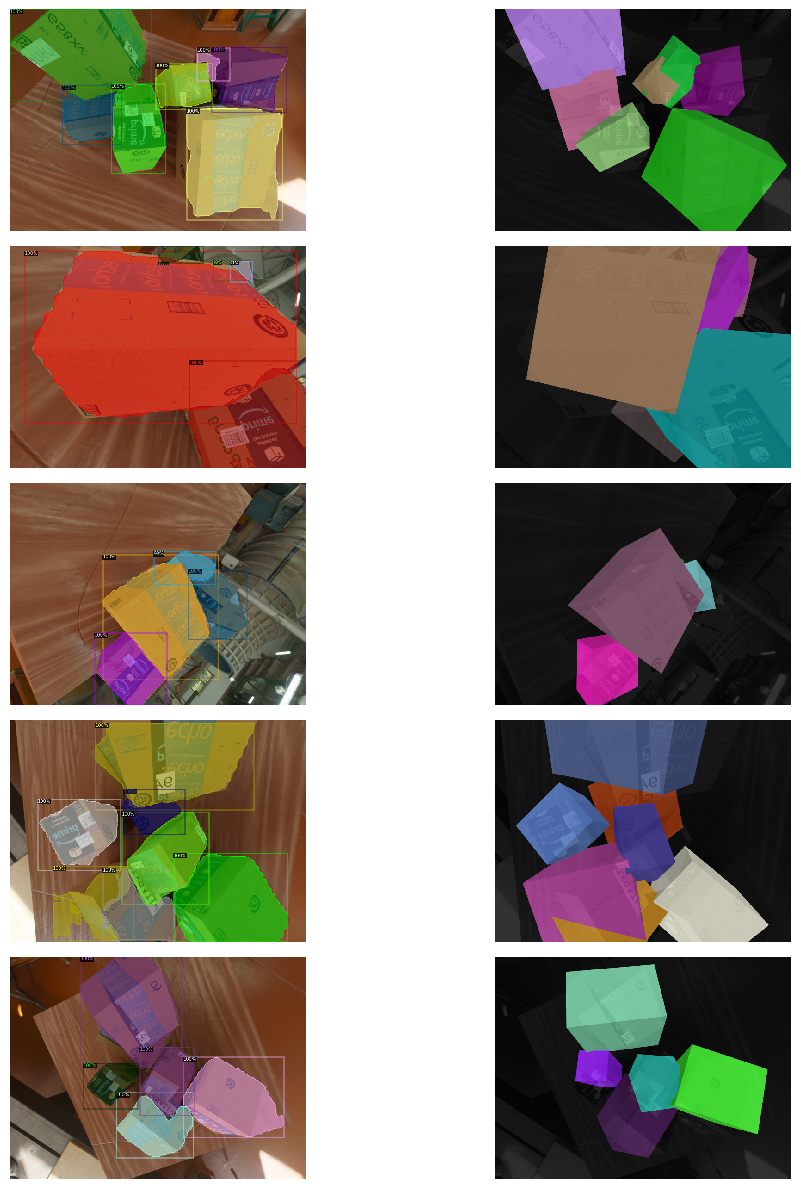

In [16]:
from scene_generation.inverse_graphics.direct_pose_and_param_estimation.debug_draw import draw_shape_and_pose_predictions

test_cfg = cfg.clone()  # cfg can be modified by model
test_cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
test_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set the testing threshold for this model, default was 0.7
test_cfg.DATASETS.TEST = ("synthetic_5_types", )

test_model = build_model(test_cfg)
test_model.eval()
test_metadata = MetadataCatalog.get(test_cfg.DATASETS.TEST[0])

checkpointer = DetectionCheckpointer(test_model)
checkpointer.load(test_cfg.MODEL.WEIGHTS)

height_to_show = 5
plt.figure(dpi=100).set_size_inches(12, 12)
test_loader_iterator = iter(test_loader)
examples = [next(test_loader_iterator)[0] for k in range(height_to_show)]
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    #inputs = {"image": image, "height": height, "width": width}
    predictions = test_model(examples)
    for k, pred in enumerate(predictions):
        im_rgb, im_boxes = draw_shape_and_pose_predictions(examples[k], pred, test_metadata)
        
        
        plt.subplot(height_to_show, 2, 2*k+1)
        cv2_imshow(im_rgb)
        plt.subplot(height_to_show, 2, 2*k+2)
        cv2_imshow(im_boxes)
plt.tight_layout()



In [7]:
# Load a 
from tqdm import tqdm

types_loader = build_detection_test_loader(
    cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))

#test_loader_iterator = iter(test_loader)#
t = tqdm(iter(types_loader), leave=False, total=len(types_loader))
all_shapes = []
gt_shapes = []
all_scores = []
with torch.no_grad():
    for i, batch in enumerate(t):
        predictions = test_model(batch)
        for inp in batch:
            gt_shapes.append(
                inp["instances"].get("gt_shape_params").cpu().detach().numpy())
        for pred in predictions:
            all_shapes.append(
                pred["instances"].get("pred_shape_params").cpu().detach().numpy())
            all_scores.append(
                pred["instances"].get("scores").cpu().detach().numpy().flatten())

[04/23 23:14:47 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(480, 480), max_size=1333, sample_style='choice'), RandomFlip()]
[04/23 23:14:47 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| prime_box  | 283          |
|            |              |
[04/23 23:14:47 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[04/23 23:14:47 d2.data.common]: Serialized dataset takes 3.05 MiB


In [17]:
from mpl_toolkits import mplot3d
import scipy.stats
all_shapes = np.vstack(all_shapes)
gt_shapes = np.vstack(gt_shapes)
all_scores = np.hstack(all_scores)


potential_sizes = np.array([
    [0.2, 0.2, 0.2],
    [0.25, 0.1, 0.1],
    [0.25, 0.2, 0.15],
    [0.1, 0.15, 0.18]
])
probs = scipy.stats.geom(p=0.33).pmf(range(1, 5))
probs = probs / np.sum(probs)
print("Probs:", probs)
sums = np.sum(potential_sizes, axis=1)
print("Sums: ", sums)

# Downselect good rows
good_rows = all_scores > 0.9
good_shapes = all_shapes[good_rows]

#bins = np.linspace(0.3, 0.7, 20)
bins = plt.hist(np.sum(good_shapes, axis=1), label="Model", alpha=0.5)
plt.hist(np.sum(gt_shapes, axis=1), bins=bins[1], label="GT", alpha=0.5)
plt.legend()
#ax = plt.axes(projection='3d')
#ax.scatter(all_shapes[:, 0], all_shapes[:, 1], all_shapes[:, 2])

NameError: name 'all_shapes' is not defined

[06/05 16:25:01 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(480, 480), max_size=1333, sample_style='choice'), RandomFlip()]
[06/05 16:25:01 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| prime_box  | 283          |
|            |              |
[06/05 16:25:01 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[06/05 16:25:01 d2.data.common]: Serialized dataset takes 3.05 MiB
Gt shape:  [0.2  0.12 0.24]
GT XYZ:  [-0.38 -0.08  1.14]


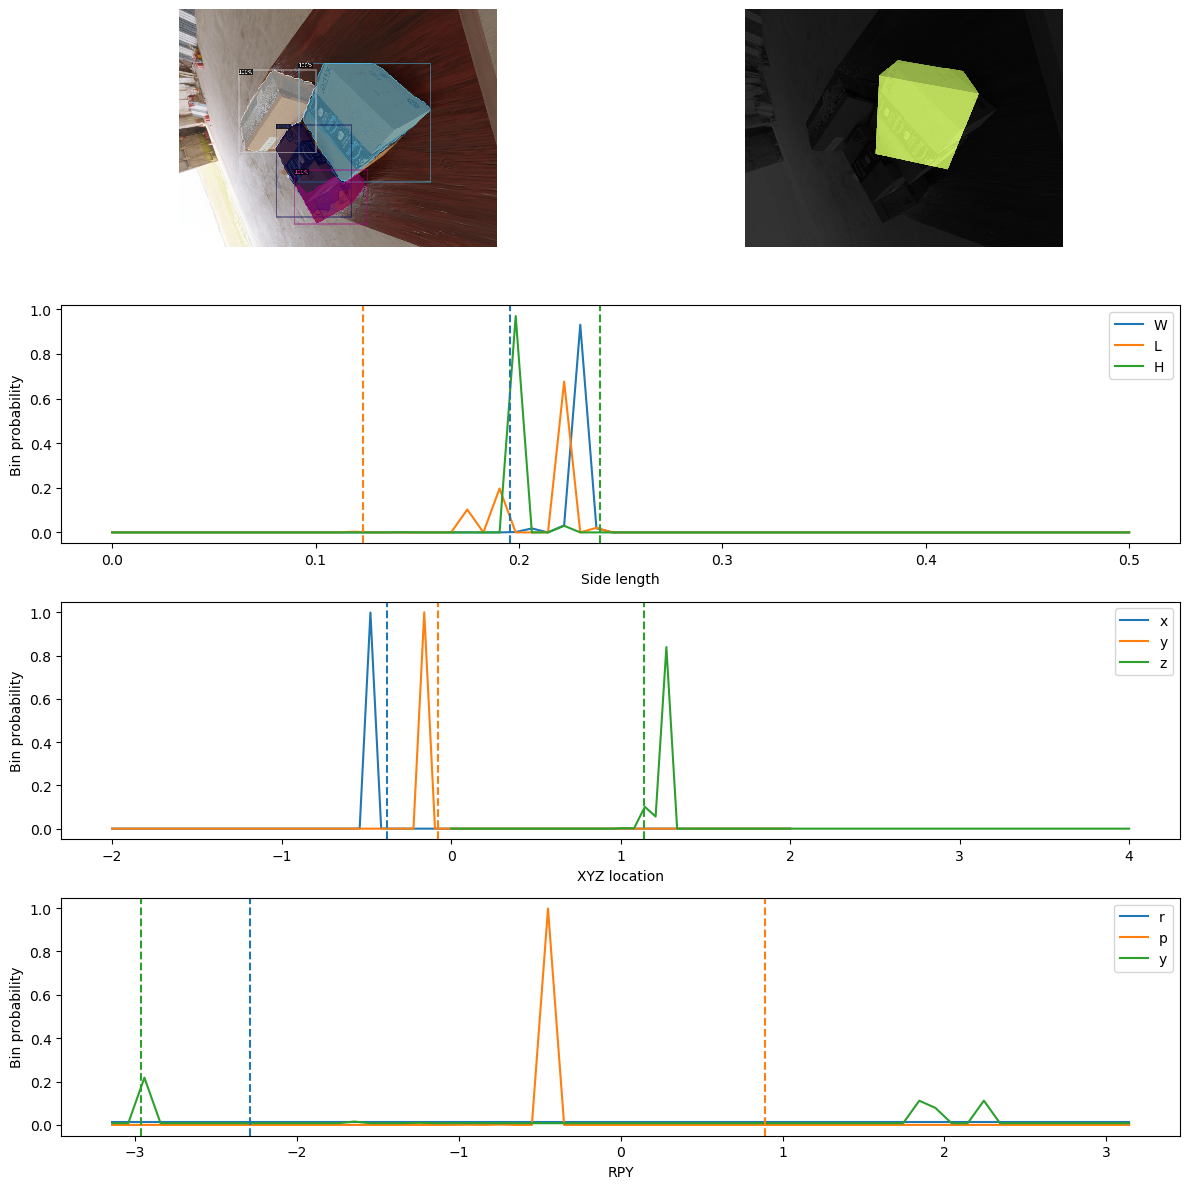

In [18]:
types_loader = iter(build_detection_test_loader(
    cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True)))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(dpi=100).set_size_inches(12, 12)
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    example = [next(types_loader) for k in range(1)][-1]
    pred = test_model(example)[0]
    im_rgb, im_boxes = draw_shape_and_pose_predictions(example[0], pred, test_metadata, instances_to_draw=[1])
    
    plt.subplot(4, 2, 1)
    cv2_imshow(im_rgb)
    plt.subplot(4, 2, 2)
    cv2_imshow(im_boxes)
    
    # Find the corresponding GT instance
    min_dist = 1000.
    gt_xyz = example[0]["instances"].get("gt_pose_quatxyz")[:, -3:].detach().cpu().numpy()
    gt_ind = np.argmin(
        np.sum(
            np.square(
                gt_xyz - pred["instances"].get("pred_pose")[0, -3:].detach().cpu().numpy()),
            axis=1))
    gt_shape = example[0]["instances"].get("gt_shape_params")[gt_ind, :].detach().cpu().numpy()
    gt_pose_rpy = example[0]["instances"].get("gt_pose_rpy")[gt_ind, :].detach().cpu().numpy()
    gt_pose_xyz = example[0]["instances"].get("gt_pose_quatxyz")[gt_ind, -3:].detach().cpu().numpy()
    print("Gt shape: ", gt_shape)
    print("GT XYZ: ", gt_pose_xyz)
    
    # SHAPE
    plt.subplot(4, 1, 2)
    shape_log_p = np.exp(pred["instances"].get("pred_shape_log_P").detach().cpu().numpy())[0, :].T
    shape_bin_ranges = model.roi_heads.shape_head.shape_bin_corners.cpu().detach().numpy().T
    plt.plot(shape_bin_ranges, shape_log_p)
    plt.ylabel("Bin probability")
    plt.xlabel("Side length")
    for k, x in enumerate(gt_shape):
        plt.axvline(x=x, color=colors[k], linestyle="--")
    plt.legend(["W", "L", "H"])
    
    # XYZ and RPY
    plt.subplot(4, 1, 3)
    pose_xyz_log_p = np.exp(pred["instances"].get("pred_pose_xyz_log_P").detach().cpu().numpy())[0, :].T
    xyz_bin_ranges = model.roi_heads.pose_xyz_head.xyz_bin_corners.cpu().detach().numpy().T
    plt.plot(xyz_bin_ranges, pose_xyz_log_p)
    plt.ylabel("Bin probability")
    plt.xlabel("XYZ location")
    for k, x in enumerate(gt_pose_xyz):
        plt.axvline(x=x, color=colors[k], linestyle="--")
    plt.legend(["x", "y", "z"])

    plt.subplot(4, 1, 4)
    pose_rpy_log_p = np.exp(pred["instances"].get("pred_pose_rpy_log_P").detach().cpu().numpy())[0, :].T
    xyz_bin_ranges = model.roi_heads.pose_xyz_head.xyz_bin_corners.cpu().detach().numpy().T
    rpy_bin_ranges = model.roi_heads.pose_rpy_head.rpy_bin_corners.cpu().detach().numpy().T 
    plt.plot(rpy_bin_ranges, pose_rpy_log_p)
    plt.ylabel("Bin probability")
    plt.xlabel("RPY")
    for k, x in enumerate(gt_pose_rpy):
        plt.axvline(x=x, color=colors[k], linestyle="--")
    plt.legend(["r", "p", "y"])

plt.tight_layout()